### Analysis software development v2 

Goal: establish smooth reading of the binary DAQ datafiles

In [1]:
import sys
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
from scipy.stats import norm


# import data handling class
from DT5550 import *

Open a datafile and read the data

In [31]:
#
# open the datfile / data directory
#
    
#
# loop over all the events
#
dt_max = 10

Etot = []
Etot_sel = []
tt = []
tt3 = []

nmax = 9999

#
# connect to the data
#
io = DT5550(indir='C:/data/20220217_092209/')

nf = 0

dtime = []
for file in io.filenames:
    io.open_data(file)
    nf = nf + 1
    if nf>nmax:
        break
    while io.read_event() == 0: 
        # data: io.Q[0:ndet-1] -> energy
        #       io.ph[0:ndet-1] -> peak height
        #       io.t[0:ndet-1] -> time without timewalk correction
        #       io.tc[0:ndet-1] -> time with timewalk correction
        #       io.valid[0:ndet-1] -> valid bit = 1 for valid data
        #       io.R[0:ndet-1] -> peak/area ratio
        
        #
        # count the number of valida hits in this event
        #
        nh = io.valid.sum()
        
        Etot.append(io.Q.sum())
        
        #
        # select events where 
        # 1. the total energy of a Na22 decay is observed
        # 2. there are 3 or more detectors that registers an energy deposit
        #
        if (nh>=3) and (io.Q.sum()>2150) and (io.Q.sum()<2400):
            #
            # 1274 gamma ray from Ne22
            #
            i0 = -1 # index of detector that registers the 1274keV event 
            for idet in range(N_DETECTOR):
                #
                # if the energy is within 100keV of the 1274keV gamma ray line, we found it (check if this is OK)
                #
                if abs(io.Q[idet]-1274)<100:
                    #print('1274keV ', idet,'t =',io.tc[idet],'E =',io.Q[idet])
                    t0 = io.tc[idet]
                    i0 = idet
         
            #
            # look at the other energy deposits in the event
            #
            nn = 0
            esum = 0
            dt = []
            for idet in range(N_DETECTOR):
                # if the hits is valid AND the detector is not the one that saw the 1274keV gamma ray
                if (io.valid[idet]) and (idet != i0):
                    nn = nn + 1
                    esum = esum + io.Q[idet]
                    dt.append(io.tc[idet]-t0) # time difference wrt to 1274keV gamma ray
            dt = np.array(dt)
            
            #
            # continue with this event if:
            # 1. there are two or more hits beside the 1274keV gamma ray (should be most, due to earlier selection)
            # 2. a 1274keV gamma ray is actually found
            #
            if (nn>=2) and (i0!=-1):
                # the energy of the hits other than the 1274keV gamma ray is within 100keV of 2*m_electron
                if abs(esum-1022)<100:
                    #
                    # calculate the variance of the time-difference of the 'other' hits
                    #
                    ss = np.sqrt(dt.var())
                    #
                    # if the other hits are within 10ns (!) then we are likely dealing with a true multi-gamma decay (mult is 2, 3, ..)
                    #
                    if ss<10: 
                        tt.append(dt.mean())
                        Etot_sel.append(io.Q.sum())
                        if nn == 3:
                            tt3.append(dt.mean())
                    
print('Processing done')

Etot = np.array(Etot,dtype=object)
Etot_sel = np.array(Etot_sel,dtype=object)
tt3 = np.array(tt3,dtype=object)


#r = np.array(r, dtype=object)

DT5550:: Data recorded with config:  C:/data/20220217_092209\config_20220217_092209.json
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_0.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_1.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_2.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_3.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_4.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_5.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_8.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_9.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_10.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_11.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_12.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_13

#### Plot time lifetime

In [44]:
def signal(t, c, a, tau):
    return c+a*np.exp(-t/tau)

tau =  100  ns lambda =  10.0 musec-1 t12 = 69.31471805599453  ns


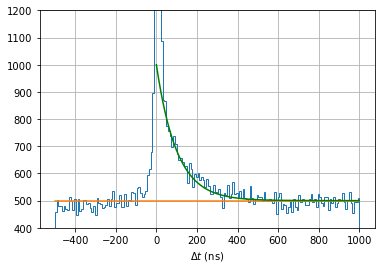

number of events 3548411


In [57]:
tt=np.array(tt)
h = plt.hist(tt,bins=175,range=(-500,1000),histtype='step')
plt.plot([-500,1000],[500,500])
plt.grid()
plt.yscale('linear')
plt.xlabel('$\Delta t$ (ns)')
xx = np.linspace(0,1000,1000)
tau=100
print('tau = ',tau,' ns lambda = ',1/tau*1000,'musec-1 t12 =',tau*np.log(2),' ns')
yy = signal(xx,500,500,tau)
plt.plot(xx,yy,color='green')
plt.ylim([400,1200])
plt.show()
print('number of events',len(tt))

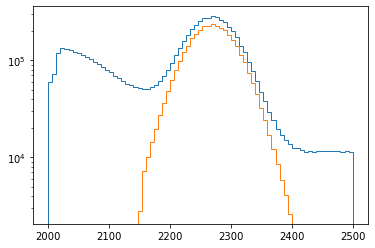

In [13]:
bins=75
plt.hist(Etot,bins=bins, range=(2000,2500), histtype='step')
plt.hist(Etot_sel,bins=bins, range=(2000,2500), histtype='step')
plt.yscale('log')
plt.show()

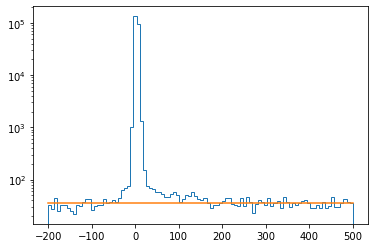

In [42]:
plt.hist(tt3,bins=100,range=(-200,500),histtype='step')
plt.plot([-200,500],[35,35])
plt.yscale('log')
plt.show()